# Introduction

The goal of this project is to investigate if there are any patterns por themes in the types of species that become endangered in different parks for the National Parks Service.

Here are a few questions this project has sought to answer: 
- How many species are in each conservation status?
- What is their distribution by category?
- How many species are considered protected?
- What is the percentage of protected vs unprotected species?
- How many observations by category are there?
- How many observations by park are there?
- Are certain types of species more likely to be endangered?
- Are the differences between species's categories and their conservation status significant?

In [1]:
#import modules 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 

#load the data
species_df = pd.read_csv('species_info.csv')
obs_df = pd.read_csv('observations.csv')

## Explore the dataframes

**species_df**

In [2]:
species_df.head(10)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN
5,Mammal,Odocoileus virginianus,White-Tailed Deer,NaN
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",NaN
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,Endangered
9,Mammal,Canis rufus,Red Wolf,Endangered


In [3]:
species_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [4]:
species_df.describe(include='all')

,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Castor canadensis,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


The conservation status column shows there are only 191 entries and 4 different kinds of status entries made. For the missing data we can assume that these species require no intervention. Category column holds 7 different types of species. Scientific names holds has more entries than unique names which means there are duplicates.

In [5]:
#fill the missing values in conservation_status 
species_df.conservation_status.fillna(value='No Intervention', inplace=True)

#list all types of species
print(f'Types of Species: {species_df.category.unique()}')

#list the different types of conservation stat
print(f'Conservation Status: {species_df.conservation_status.unique()}')

Types of Species: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
Conservation Status: ['No Intervention' 'Species of Concern' 'Endangered' 'Threatened'
 'In Recovery']


In [6]:
#rank conservation status types. no intervnetion < in recovery <species of concern < threatened < endangered
species_df.conservation_status = pd.Categorical(species_df.conservation_status, ['No Intervention' , 'In Recovery' , 'Species of Concern' , 'Threatened' , 'Endangered'], ordered=True)

species_df.conservation_status.unique()

['No Intervention', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Categories (5, object): ['No Intervention' < 'In Recovery' < 'Species of Concern' < 'Threatened' < 'Endangered']

In [7]:
# sort dataframe by conservation status 
species_df.sort_values('conservation_status', ascending=True, inplace=True)

#removing rows with duplicate scientific names recorded keeping the rows of duplicates where species are closest to extinction 
species_df.drop_duplicates('scientific_name', keep='last', inplace=True)

species_df.shape

(5541, 4)

**obs_df**

In [8]:
obs_df.head(10)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85
5,Elymus virginicus var. virginicus,Yosemite National Park,112
6,Spizella pusilla,Yellowstone National Park,228
7,Elymus multisetus,Great Smoky Mountains National Park,39
8,Lysimachia quadrifolia,Yosemite National Park,168
9,Diphyscium cumberlandianum,Yellowstone National Park,250


In [9]:
obs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


In [10]:
#check for duplicate observation recordings using the scientific_name and park_name column 
obs_df.duplicated(['scientific_name', 'park_name']).value_counts()

False    22164
True      1132
dtype: int64

1132 duplicated values we will order dataframe by observation and keep the lowest of the values 

In [11]:
obs_df = obs_df.sort_values('observations').drop_duplicates(subset=['scientific_name', 'park_name'], keep='last')
obs_df.shape

(22164, 3)

In [12]:
#list all parks in dataset 
print(f'Number of Parks: {obs_df.park_name.nunique()}')
print(f'Parks: {obs_df.park_name.unique()}')

Number of Parks: 4
Parks: ['Bryce National Park' 'Great Smoky Mountains National Park'
 'Yosemite National Park' 'Yellowstone National Park']


In [13]:
#merging both dataframes 
full_df = pd.merge(species_df, obs_df)
full_df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,Great Smoky Mountains National Park,98
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,Yosemite National Park,117
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,Bryce National Park,130
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,Yellowstone National Park,270
4,Vascular Plant,Apocynum cannabinum var. cannabinum,Indian Hemp,No Intervention,Great Smoky Mountains National Park,68


### How many species are in each conservation status?

In [14]:
#conservation statsus of all species in df 
species_df.conservation_status.value_counts().reset_index()
conservation_spec = species_df.conservation_status.value_counts(normalize=True).reset_index()
conservation_spec.head(10)

,index,conservation_status
0,No Intervention,0.967695
1,Species of Concern,0.027251
2,Endangered,0.002707
3,Threatened,0.001805
4,In Recovery,0.000541


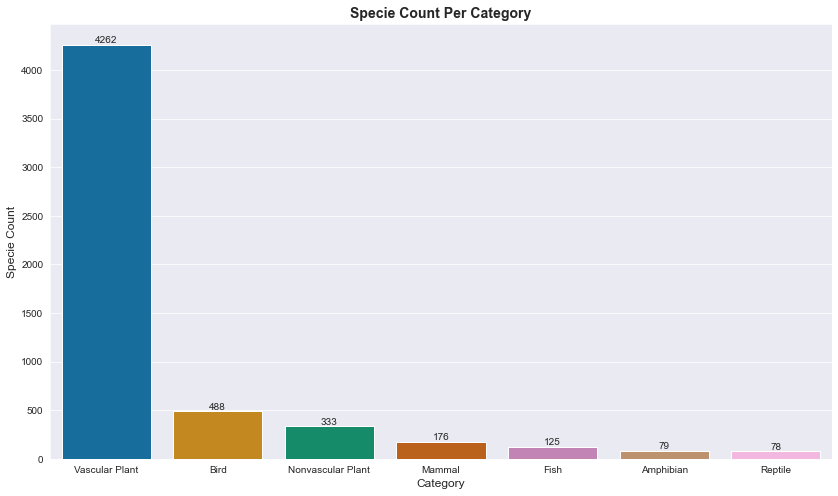

<Figure size 432x288 with 0 Axes>

In [15]:
#find out conservation status frequency of types of species 
specie_type_freq = species_df.category.value_counts().reset_index().rename(columns={'category':'count', 'index':'category'})

#create bar chart for visualizing specie count per category. 
plt.figure(figsize=[14, 8])
sns.set_style('darkgrid')
ax = sns.barplot(x='category', y='count',data=specie_type_freq, palette='colorblind')
plt.xticks(rotation=0, fontsize=10)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Specie Count', fontsize=12)
plt.title('Specie Count Per Category', weight='bold', fontsize=14)
plt.bar_label(ax.containers[0])
plt.show()
plt.clf()

Approximately 97% of the species observed in the national park currently require no intervention. Of the 3%, 3 species are currently in recovery, 151 classified as a species concern, 9 are threatened and 15 are endangered. Vascular plants make up 77% percent of species found in the parks. The second most common type of species found is birds with 488 different species and the least most common types species being reptiles and amphibians with 78 and 79 different species respectively. 

### What is their distribution by category?

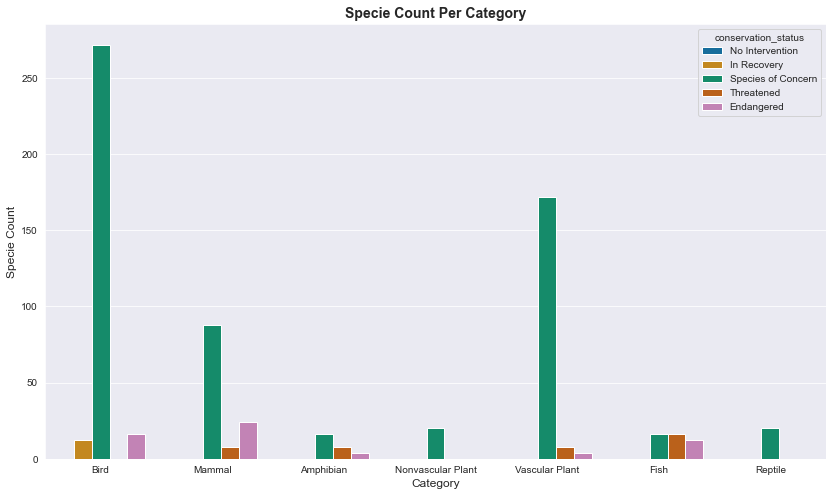

<Figure size 432x288 with 0 Axes>

In [16]:
#create dataframes excluding species that require no intervention
species_protected = species_df[species_df.conservation_status!='No Intervention']
full_protected = full_df[full_df.conservation_status!='No Intervention']

#create bar chart for visualizing specie count per category. 
plt.figure(figsize=[14, 8])
sns.set_style('darkgrid')
ax = sns.countplot(x='category', data=full_protected, palette='colorblind', hue='conservation_status')
plt.xticks(rotation=0, fontsize=10)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Specie Count', fontsize=12)
plt.title('Specie Count Per Category', weight='bold', fontsize=14)
plt.bar_label(ax.containers[0])
plt.show()
plt.clf()

All types the categories species are mostly species of concern except fish which has an equal amount of species in recovery as well as concern. Birds and vascular plants have the most number of species combined in the national parks that are under threat of possible extinction. The reptiles, amphibian and non vascular plant have the fewest number of species under threat. 

### How many species are considered protected?

In [17]:
#create a new column to identify protected species
species_df['protected'] = species_df.conservation_status != 'No Intervention'

protection = species_df.groupby(['category', 'protected']).scientific_name.count().reset_index()
protection = protection.pivot(columns='protected', index='category', values='scientific_name').reset_index()
protection = protection.rename(columns={'protected':'',False:'not_protected', True:'protected'})
protection = protection.rename_axis(None, axis=1)  

# sum of protected vs unprotected 
print(f'Total number of protected species: {protection.protected.sum()}')
print(f'Total number of un-protected species: {protection.not_protected.sum()}')


Total number of protected species: 179
Total number of un-protected species: 5362


### What is the percentage of protected vs unprotected species?

In [18]:
#cehck what percentage of each category is protected
protection['protection_percentage'] = round(protection['protected'] /( protection['protected'] + protection['not_protected'])*100, 2)
protection

,category,not_protected,protected,protection_percentage
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,114,11,8.80
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


Mammal are more likely to be endangered than birds, amphibians and fish have the highest rate of being under protection in the parks. 


### How many protected observations by category are there?

In [19]:
cat_obs = full_protected.groupby('category').observations.sum().reset_index().sort_values('observations', ascending=False)
cat_obs

,category,observations
1,Bird,36682
6,Vascular Plant,22849
3,Mammal,13313
2,Fish,3933
0,Amphibian,2752
4,Nonvascular Plant,2705
5,Reptile,2536


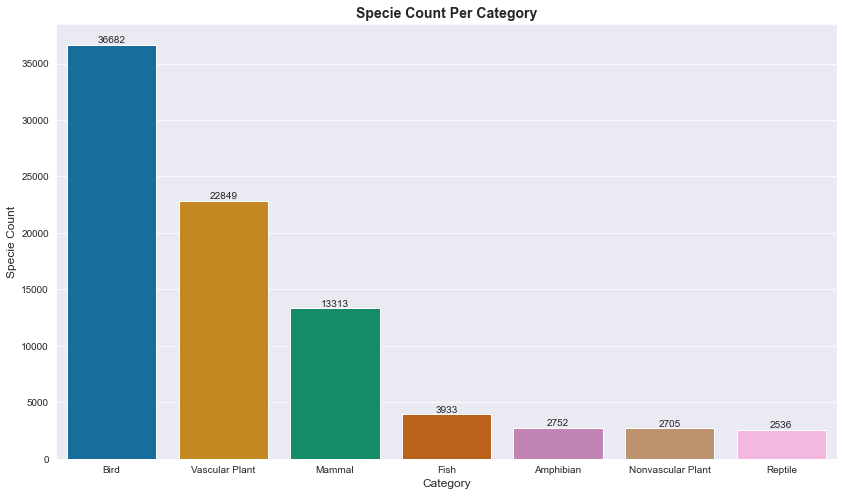

<Figure size 432x288 with 0 Axes>

In [20]:
#create bar chart for visualizing total observations per category. 
plt.figure(figsize=[14, 8])
sns.set_style('darkgrid')
ax = sns.barplot(x='category', y='observations',data=cat_obs, palette='colorblind')
plt.xticks(rotation=0, fontsize=10)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Specie Count', fontsize=12)
plt.title('Specie Count Per Category', weight='bold', fontsize=14)
plt.bar_label(ax.containers[0])
plt.show()
plt.clf()

Valsuclar plants are very abundant even among the protected species. The category with the second most observations happens to be birds. Amphibians and reptiles had the least observations. 

### How many observations by park are there?

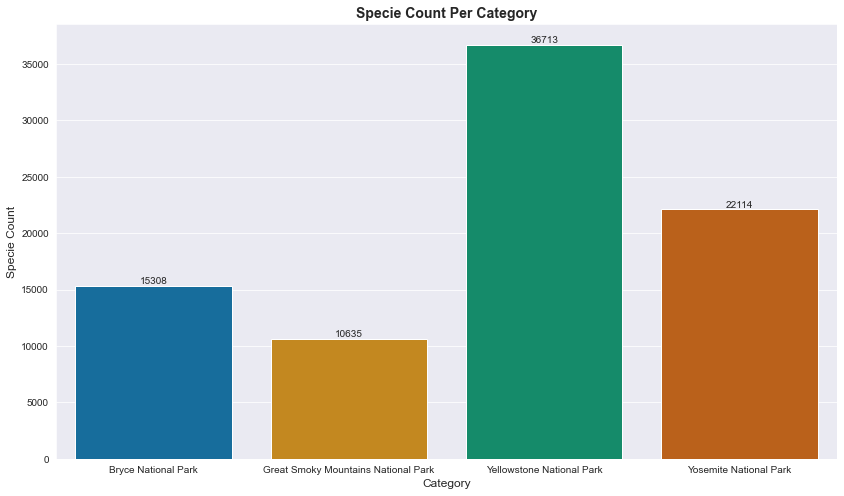

<Figure size 432x288 with 0 Axes>

In [21]:
park_obs = full_protected.groupby('park_name').observations.sum().reset_index()

#create bar chart for visualizing total observations per park. 
plt.figure(figsize=[14, 8])
sns.set_style('darkgrid')
ax = sns.barplot(x='park_name', y='observations',data=park_obs, palette='colorblind')
plt.xticks(rotation=0, fontsize=10)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Specie Count', fontsize=12)
plt.title('Specie Count Per Category', weight='bold', fontsize=14)
plt.bar_label(ax.containers[0])
plt.show()
plt.clf()

Yellowstone has the highest number of observations out of all the parks, with the great smoky mountains having the least number of sightings

**Lets create a dateframe with the park_name, category and observations.**

In [23]:
types_in_park = full_protected.groupby(['park_name', 'conservation_status']).observations.sum().reset_index()
types_in_park

,park_name,conservation_status,observations
0,Bryce National Park,No Intervention,0
1,Bryce National Park,In Recovery,258
2,Bryce National Park,Species of Concern,14085
3,Bryce National Park,Threatened,532
4,Bryce National Park,Endangered,433
5,Great Smoky Mountains National Park,No Intervention,0
6,Great Smoky Mountains National Park,In Recovery,189
7,Great Smoky Mountains National Park,Species of Concern,9740
8,Great Smoky Mountains National Park,Threatened,401
9,Great Smoky Mountains National Park,Endangered,305


In [29]:
# plt.figure(figsize=[20,15], dpi=300)
# plt.pie(y='park_name', x='observations' ,data=types_in_park, palette='colorblind', hue='conservation_status')
# plt.xticks(rotation=0, fontsize=12)
# plt.yticks(rotation=0, fontsize=12)
# plt.xlabel('Total Observations', fontsize=15)
# plt.ylabel('Conservation Status', fontsize=15)
# plt.title('Specie Count Per Category', weight='bold', fontsize=14)
# plt.show()
# plt.clf()


### Are certain types of species more likely to be endangered?

In [27]:
#use chi2_contigency to caclculate significant difference
from scipy.stats import chi2_contingency


xtab1 = [[413, 75],
       [146, 30]]

chi2, pval, dof, expected = chi2_contingency(xtab1)
print(pval)

0.6875948096661336


In [28]:
xtab2 = [[72,7],
        [146, 30]]
chi2, pval, dof, expected = chi2_contingency(xtab2)
print(pval)

0.12757669693198975


The differences between species's categories, conservation status is significant. pval is less then the threshold of 0.05. This means the species do not have similar conservation statuses.